In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import ts_ad

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [11]:
log_dir = "./final/ts_ad_rmse_sim"

input_len = 1024
output_len = 128

horizon = input_len + output_len
stride = 512

batch_size = 16

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [12]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [13]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


In [14]:
train_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride), input_len),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_test, horizon=horizon, stride=output_len), input_len),
    batch_size,
    shuffle=False,
)


# Model

In [15]:
base_width = 128
down_layers = 3

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width)
model = simple_conv.SimpleConv(backbone, data.NUM_FEATURES, output_len)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = ts_ad.TSADEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
)


# Training

In [16]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss=0.911 - test_loss=0.911 - cost=0.185 - threshold=2.002 - lr=1.00e-03


Epoch 1 - train_loss=0.925 - test_loss=0.902 - cost=0.185 - threshold=1.980 - lr=9.76e-04


Epoch 2 - train_loss=0.899 - test_loss=0.905 - cost=0.185 - threshold=1.999 - lr=9.05e-04


Epoch 3 - train_loss=0.883 - test_loss=0.900 - cost=0.185 - threshold=1.997 - lr=7.94e-04


Epoch 4 - train_loss=0.880 - test_loss=0.900 - cost=0.185 - threshold=1.967 - lr=6.55e-04


Epoch 5 - train_loss=0.898 - test_loss=0.899 - cost=0.185 - threshold=1.970 - lr=5.00e-04


Epoch 6 - train_loss=0.902 - test_loss=0.899 - cost=0.185 - threshold=1.983 - lr=3.45e-04


Epoch 7 - train_loss=0.918 - test_loss=0.898 - cost=0.185 - threshold=1.990 - lr=2.06e-04


Epoch 8 - train_loss=0.966 - test_loss=0.898 - cost=0.185 - threshold=1.971 - lr=9.55e-05


Epoch 9 - train_loss=0.912 - test_loss=0.898 - cost=0.185 - threshold=1.969 - lr=2.45e-05


# Evaluating

In [17]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [18]:
# Cost model
cmodel = metrics.default_cmodel()


In [19]:
scores, labels = get_predictions(engine.predict, test_loader)


100%|██████████| 154/154 [00:22<00:00,  6.88it/s]


In [20]:
cmodel.fit(scores, labels).optimize()


(1.9691893322765823, 0.18494259)

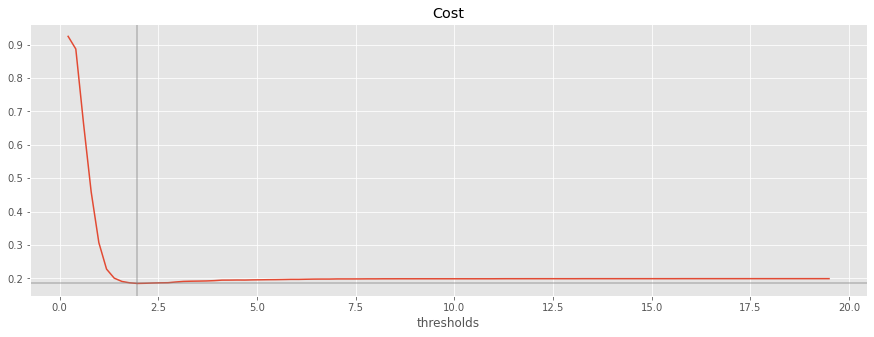

In [21]:
metrics.plot_cost(cmodel)


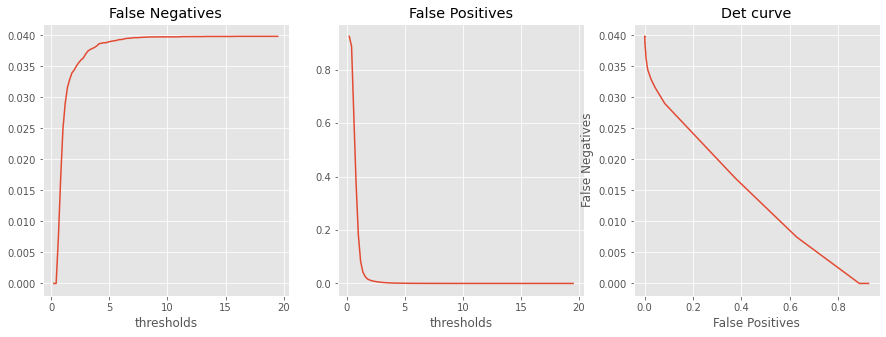

In [22]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


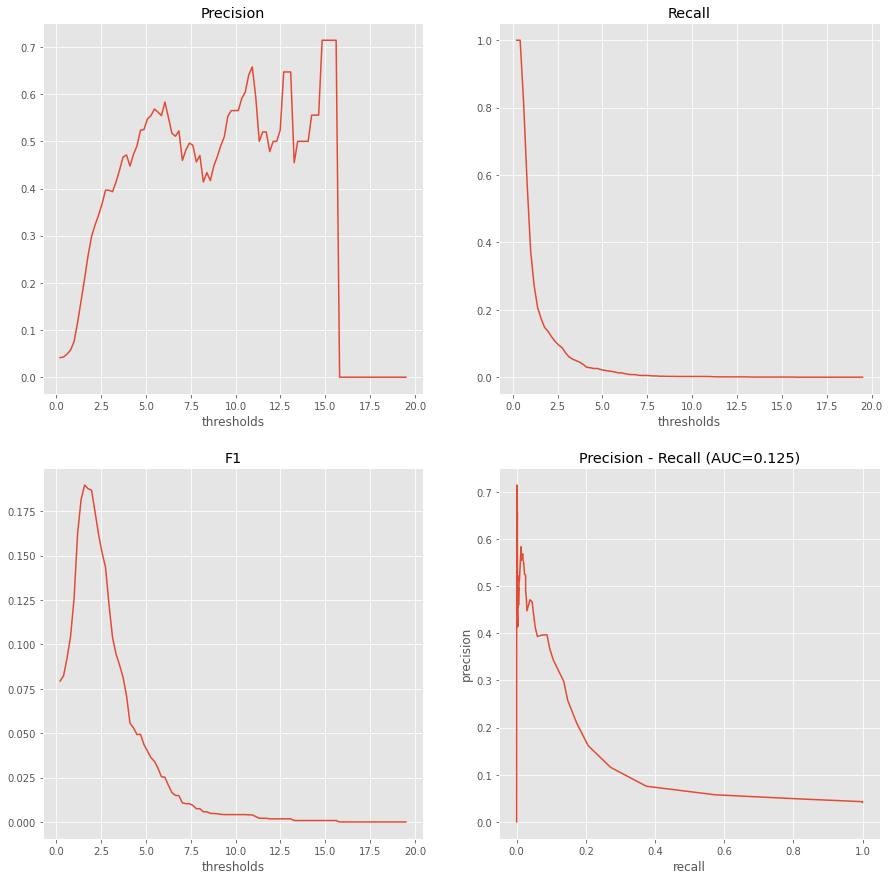

In [23]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)

In [25]:
batch = next(iter(test_loader))

In [27]:
for l, d in batch.items():
    print(l, d.size())

data torch.Size([16, 1024, 460])
target torch.Size([16, 128, 460])
label torch.Size([16, 128])


In [30]:
model.eval()
inputs = batch["data"].to(device)
target = batch["target"].to(device)

outs = model(inputs)
preds = engine.errors(outs, target)
print(outs.size(), preds.size())

torch.Size([16, 128, 460])

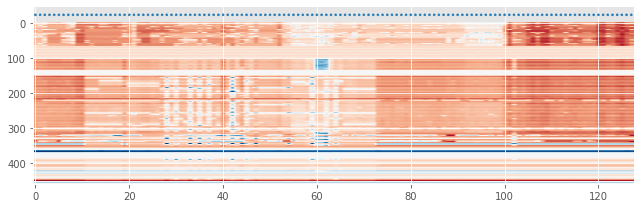

In [39]:
from common.nn import plot_dataframe, pd

plot_dataframe(pd.DataFrame(batch["target"][0]), labels=pd.Series(batch["label"][0]))

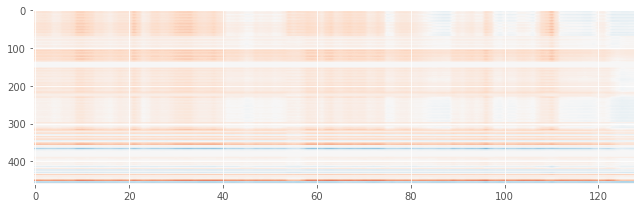

In [40]:
plot_dataframe(pd.DataFrame(outs[0].detach().cpu()), labels=pd.Series(preds[0].detach().cpu()))
